# PRETRATAMIENTO DATASET SPACENET

En el presente notebook se realizaran los trabajos necesarios para preparar las imágenes del dataset Spacenet para que puedan ser usadas en el entrenamiento del modelo Segformer.

## Configuración

In [ ]:
# importamos las librerias necesarias
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import files, drive

In [ ]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/spacenet/"

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Descargar Dataset

Este dataset se encuentra en la plataforma Kaggle por lo que lo podemos descargar directamente desde el cuaderno.

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=646c261b20596f5c7afae7a9a026042338723e5a6a4c1127dd9daa66db5a8061
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
# Seleccionar el Token personal de la API previamente descargada (fichero kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avr185","key":"2c2c6ff7c355d927c86b8b46e6ee30ff"}'}

In [ ]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Ya podemos listar los datasets disponibles en kaggle para su descarga
!kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           8983        295  1.0              
josephinelsy/spotify-top-hit-playlist-2010-2022            Spotify Top Hit Playlist (2010-2022)           210KB  2023-09-08 06:11:44           1598         48  1.0              
nelgiriyewithana/global-youtube-statistics-2023            Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          18655        587  1.0              
muhammadtalhaawan/world-export-and-import-dataset          World Export & Import Dataset (1989 - 2023)    721K

In [ ]:
# Descarga
!kaggle datasets download -d amerii/spacenet-7-multitemporal-urban-development

100% 10.3G/10.3G [02:21<00:00, 89.1MB/s]
100% 10.3G/10.3G [02:21<00:00, 78.6MB/s]


In [ ]:
# Creemos un directorio para descomprimir los datos
!mkdir "$ROOT_DIR"

# Descomprimimos los datos y los dejamos listos para trabajar
!unzip spacenet-7-multitemporal-urban-development.zip -d "$ROOT_DIR"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-1138E-1216N_4553_3325_13/labels_match_pix/global_monthly_2019_02_mosaic_L15-1138E-1216N_4553_3325_13_Buildings.geojson  
  inflating: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-1138E-1216N_4553_3325_13/labels_match_pix/global_monthly_2019_03_mosaic_L15-1138E-1216N_4553_3325_13_Buildings.geojson  
  inflating: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-1138E-1216N_4553_3325_13/labels_match_pix/global_monthly_2019_04_mosaic_L15-1138E-1216N_4553_3325_13_Buildings.geojson  
  inflating: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-1138E-1216N_4553_3325_13/labels_match_pix/global_monthly_2019_05_mosaic_L15-1138E-1216N_4553_3325_13_Buildings.geojson  
  inflating: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-1138E-1216N_4553_332

## Explorar Dataset

Localización geográfica de las imágenes del dataset:

<a rel="noreferrer nofollow" target="_blank" href="https://avanetten.github.io/SpaceNet7/sn7_aois_public.html"><img alt="" src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F4101651%2F00efe465e1ebacee12041d3a1a0f7330%2Flocations.png?generation=1605455025260931&amp;alt=media">
</a>


Hay varias carpetas en este dataset, la que nos interesa es <b>SN7_buildings_train</b> que es donde vienen las distintas imágenes de entrenamiento.

In [ ]:
!ls "$ROOT_DIR"

SN7_buildings_test_public  SN7_buildings_train_csvs
SN7_buildings_train	   SN7_buildings_train_sample


Dentro de este directorio a su vez se encuentra un directorio de carpetas para cada una de las localizaciones geográficas, y todas ellas cuentan en su interior con las dos carpetas que nos interesan:
- images_masked: imágenes de entrenamiento a las que han recortado los obstáculos como nubes.
- labels_match: ficheros geojson que será necesario convertir a imágenes binarias para trabajar de forma similar que en el dataset de INRIA.



In [ ]:
ROOT_DIR = os.path.join(ROOT_DIR, "SN7_buildings_train/train")
IMAGES_SUBDIR = "images_masked"
LABELS_SUBDIR = "labels_match"

!ls "$ROOT_DIR"

L15-0331E-1257N_1327_3160_13  L15-1203E-1203N_4815_3378_13
L15-0357E-1223N_1429_3296_13  L15-1204E-1202N_4816_3380_13
L15-0358E-1220N_1433_3310_13  L15-1204E-1204N_4819_3372_13
L15-0361E-1300N_1446_2989_13  L15-1209E-1113N_4838_3737_13
L15-0368E-1245N_1474_3210_13  L15-1210E-1025N_4840_4088_13
L15-0387E-1276N_1549_3087_13  L15-1276E-1107N_5105_3761_13
L15-0434E-1218N_1736_3318_13  L15-1289E-1169N_5156_3514_13
L15-0457E-1135N_1831_3648_13  L15-1296E-1198N_5184_3399_13
L15-0487E-1246N_1950_3207_13  L15-1298E-1322N_5193_2903_13
L15-0506E-1204N_2027_3374_13  L15-1335E-1166N_5342_3524_13
L15-0544E-1228N_2176_3279_13  L15-1389E-1284N_5557_3054_13
L15-0566E-1185N_2265_3451_13  L15-1438E-1134N_5753_3655_13
L15-0571E-1075N_2287_3888_13  L15-1439E-1134N_5759_3655_13
L15-0577E-1243N_2309_3217_13  L15-1479E-1101N_5916_3785_13
L15-0586E-1127N_2345_3680_13  L15-1481E-1119N_5927_3715_13
L15-0595E-1278N_2383_3079_13  L15-1538E-1163N_6154_3539_13
L15-0614E-0946N_2459_4406_13  L15-1615E-1205N_6460_3370_

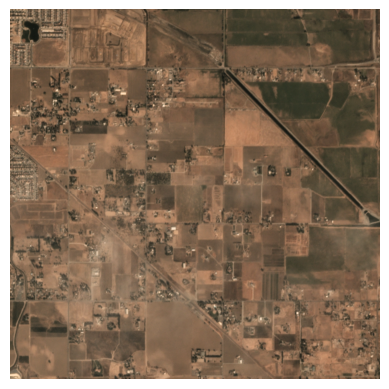

In [ ]:
folder = os.listdir(ROOT_DIR)[0]
path = os.path.join(ROOT_DIR, folder, IMAGES_SUBDIR)

# Listar todos los archivos del directorio
images = [f for f in os.listdir(path)]

# Seleccionar un archivo de forma aleatoria
random_img = random.choice(images)
random_img_path = os.path.join(path, random_img)

# Mostrar la imagen
with Image.open(random_img_path) as img:
    plt.imshow(img)
    plt.axis('off')  # No mostrar ejes
    plt.show()

En este caso las imágenes tienen un tamaño aceptable para usar durante el entrenamiento, aunque como se puede observar arriba los edificios se visualizan muy pequeños.

In [ ]:
print(f"Número total de imágenes: {len(images)}")

sample_img = Image.open(random_img_path)
print(f"Dimensiones de las imágenes (Alto x Ancho): {sample_img.size}")
print(f"Espacio en disco de una imagen de muestra: {os.path.getsize(random_img_path) / (1024*1024):.2f} MB")

Número total de imágenes: 25
Dimensiones de las imágenes (Alto x Ancho): (1024, 1023)
Espacio en disco de una imagen de muestra: 4.00 MB


Vamos a recorrer el árbol de carpetas (cada carpeta corresponde a una localización geográfica del planeta) y comprobaremos el número de imágenes que tenemos para cada una de ellas:

In [ ]:
# 3. Número de imágenes para cada localización
def count_tif_images_in_subdirectories(main_directory):
    # Recorremos los subdirectorios del directorio principal
    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        # Comprobamos si es un directorio
        if os.path.isdir(subdir_path):
            # Construimos la ruta a la carpeta "images_masked" dentro del subdirectorio
            images_masked_path = os.path.join(subdir_path, "images_masked")

            # Comprobamos si existe la carpeta "images_masked"
            if os.path.exists(images_masked_path):
                # Contamos las imágenes .tif en la carpeta "images_masked"
                tif_files = [f for f in os.listdir(images_masked_path) if f.endswith('.tif')]
                num_images = len(tif_files)

                # Imprimimos el resultado
                print(f'La carpeta "{subdir}" contiene {num_images} imágenes .tif.')


count_tif_images_in_subdirectories(ROOT_DIR)

La carpeta "L15-0331E-1257N_1327_3160_13" contiene 25 imágenes .tif.
La carpeta "L15-0357E-1223N_1429_3296_13" contiene 25 imágenes .tif.
La carpeta "L15-0358E-1220N_1433_3310_13" contiene 24 imágenes .tif.
La carpeta "L15-0361E-1300N_1446_2989_13" contiene 24 imágenes .tif.
La carpeta "L15-0368E-1245N_1474_3210_13" contiene 24 imágenes .tif.
La carpeta "L15-0387E-1276N_1549_3087_13" contiene 22 imágenes .tif.
La carpeta "L15-0434E-1218N_1736_3318_13" contiene 25 imágenes .tif.
La carpeta "L15-0457E-1135N_1831_3648_13" contiene 24 imágenes .tif.
La carpeta "L15-0487E-1246N_1950_3207_13" contiene 25 imágenes .tif.
La carpeta "L15-0506E-1204N_2027_3374_13" contiene 24 imágenes .tif.
La carpeta "L15-0544E-1228N_2176_3279_13" contiene 24 imágenes .tif.
La carpeta "L15-0566E-1185N_2265_3451_13" contiene 21 imágenes .tif.
La carpeta "L15-0571E-1075N_2287_3888_13" contiene 20 imágenes .tif.
La carpeta "L15-0577E-1243N_2309_3217_13" contiene 21 imágenes .tif.
La carpeta "L15-0586E-1127N_2345_3

In [ ]:
# 5. Mostrar las características de las imágenes
img_array = np.array(sample_img)
print(f"Número de canales: {img_array.shape[2]}")
print(f"Valores únicos en la imagen de muestra:\n{np.unique(img_array)}")

Número de canales: 4
Valores únicos en la imagen de muestra:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 23

Estas imágenes .tif tienen un canal extra aparte de los típicos RGB con información geoespacial. De cara al entrenamiento este canal nos interesa quitarlo.

## Creación de las máscaras a partir de los ficheros GeoJSON

En este dataset de partida no tenemos máscaras binarias, lo que sería el caso ideal, pero en cambio tenemos ficheros GeoJSON para cada una de las imágenes y esto nos permite confeccionar estas máscaras gracias a los datos que contienen.

Configuraciones necesarias para completar este proceso.

In [ ]:
!pip install rasterio geopandas shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/spacenet/"

DATASET_DIR = os.path.join(ROOT_DIR, "SN7_buildings_train/train/")

OUTPUT_IMAGES_DIR = os.path.join(ROOT_DIR, "Images")
OUTPUT_MASKS_DIR = os.path.join(ROOT_DIR, "Masks")

FINAL_IMAGES_DIR = "/content/drive/MyDrive/TFM/dataset/Processed Images"

In [ ]:
# Si fuese necesario
from google.colab import files, drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Función para leer y reproyectar el GeoJSON al CRS de la imagen raster
def reproject_geojson_to_raster_crs(geojson_path, raster_path):
    # Lee el archivo GeoJSON
    gdf = gpd.read_file(geojson_path)

    # Verifica si geopandas ha detectado el CRS
    if not gdf.crs:
        # Establece el CRS manualmente (en este caso, WGS 84)
        gdf.set_crs(epsg=4326, inplace=True)

    # Reproyecta el GeoDataFrame al CRS de la imagen raster
    with rasterio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)

    return gdf

In [ ]:
# Función para crear una máscara binaria basada en geometrías GeoJSON y una imagen raster
def create_binary_mask_from_geojson(geojson_path, raster_path, output_mask_path):
    gdf = reproject_geojson_to_raster_crs(geojson_path, raster_path)
    features = [feature["geometry"] for feature in gdf.iterfeatures()]

    with rasterio.open(raster_path) as src:
        mask = geometry_mask(features, transform=src.transform, invert=True, out_shape=src.shape)
        mask = (mask * 255).astype(np.uint8)  # Convertimos a valores 0 y 255
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff", "dtype": 'uint8', "count": 1})

    with rasterio.open(output_mask_path, "w", **out_meta) as dest:
        dest.write(mask, 1)

In [ ]:
def is_black_image(image_path):
    """Verifica si una imagen es completamente negra."""
    with rasterio.open(image_path) as src:
        data_sum = src.read().sum()
    return data_sum == 0

In [ ]:
def process_directory_structure(main_directory, output_images_dir, output_masks_dir, image_counter):

    # Recorremos los subdirectorios del directorio principal
    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path):
            images_masked_path = os.path.join(subdir_path, "images_masked")
            labels_match_path = os.path.join(subdir_path, "labels_match")

            if os.path.exists(images_masked_path) and os.path.exists(labels_match_path):
                for filename in os.listdir(images_masked_path):
                    if filename.endswith('.tif'):
                        # Construye las rutas completas
                        image_path = os.path.join(images_masked_path, filename)

                        # Verifica si la imagen es completamente negra
                        if is_black_image(image_path):
                            print(f"Omitiendo imagen negra: {image_path}")
                            continue

                        geojson_name = filename.rsplit('.', 1)[0] + '_Buildings.geojson'
                        geojson_path = os.path.join(labels_match_path, geojson_name)

                        # Si el archivo geojson correspondiente existe se procede
                        if os.path.exists(geojson_path):
                            image_counter += 1

                            output_image_name = f"{image_counter}.tif"
                            output_mask_name = f"{image_counter}.tif"

                            output_image_path = os.path.join(output_images_dir, output_image_name)
                            output_mask_path = os.path.join(output_masks_dir, output_mask_name)

                            # Crear máscara
                            try:
                              create_binary_mask_from_geojson(geojson_path, image_path, output_mask_path)
                            except ValueError as e:
                              print(f"Error al procesar GeoJSON: {geojson_path} con imagen: {image_path}. Error: {e}")

                            # Copia y modifica la imagen
                            with rasterio.open(image_path) as src:
                                image_data = src.read([1, 2, 3])  # Solo toma los canales RGB
                                out_meta = src.meta.copy()
                                out_meta.update({"count": 3})  # Actualiza el número de canales

                                with rasterio.open(output_image_path, "w", **out_meta) as dest:
                                    dest.write(image_data)


In [ ]:
# Verificación de ficheros existentes e indice a seguir
existing_files = os.listdir(FINAL_IMAGES_DIR)

existing_numbers = [int(f.split('.')[0]) for f in existing_files if not f.startswith("empty_")]
max_number = max(existing_numbers, default=0)

print(f"Numeración a seguir en función de las imágenes ya presentes en el dataset listo para el entrenamiento:\n{max_number}")

# Asegurarte de que los directorios de salida existan
if not os.path.exists(OUTPUT_IMAGES_DIR):
    os.makedirs(OUTPUT_IMAGES_DIR)
if not os.path.exists(OUTPUT_MASKS_DIR):
    os.makedirs(OUTPUT_MASKS_DIR)

# Llamada a la función principal
process_directory_structure(DATASET_DIR, OUTPUT_IMAGES_DIR, OUTPUT_MASKS_DIR, max_number)

Numeración a seguir en función de las imágenes ya presentes en el dataset listo para el entrenamiento:
1825
Omitiendo imagen negra: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/images_masked/global_monthly_2018_10_mosaic_L15-0457E-1135N_1831_3648_13.tif
Omitiendo imagen negra: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/images_masked/global_monthly_2019_08_mosaic_L15-0457E-1135N_1831_3648_13.tif
Omitiendo imagen negra: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/images_masked/global_monthly_2019_07_mosaic_L15-0457E-1135N_1831_3648_13.tif
Omitiendo imagen negra: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/images_masked/global_monthly_2019_11_mosaic_L15-0457E-1135N_1831_3648_13.tif
Omitiendo imagen negra: /content/drive/MyDrive/TFM/dataset/spacenet/SN7_buildings_train/trai

> Visualización de los resultados

Vamos a comprobar si el trabajo realizado es correcto.

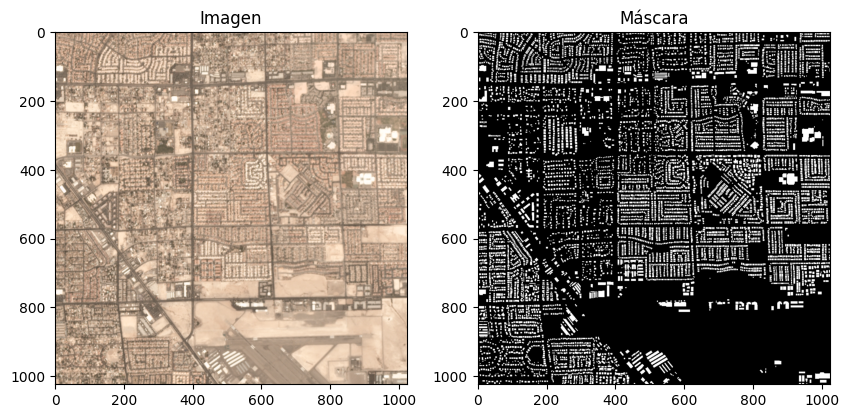

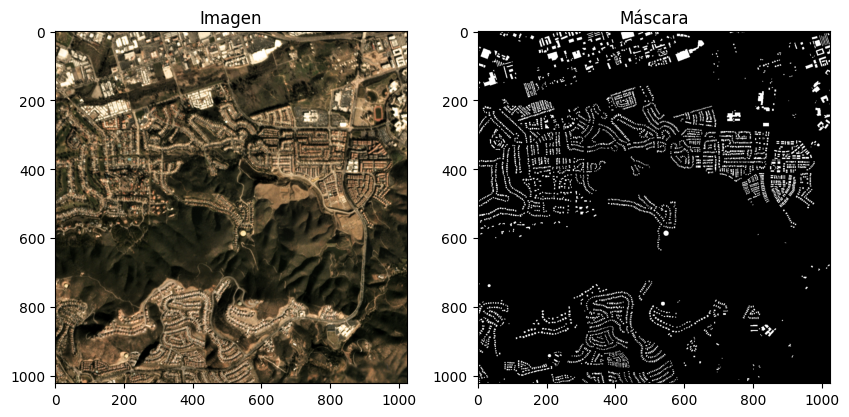

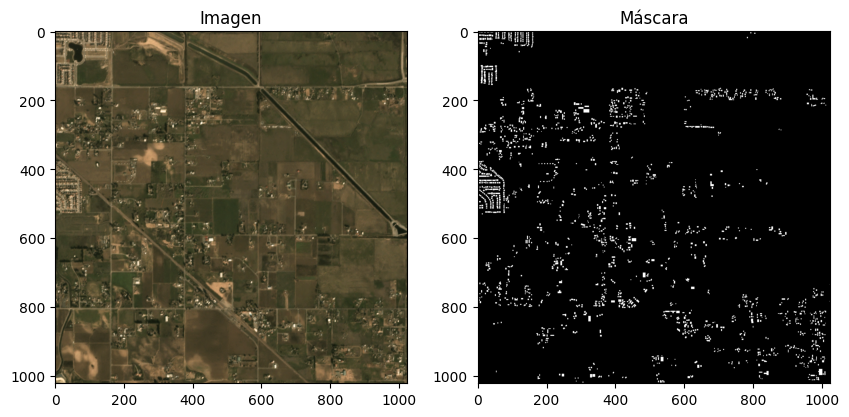

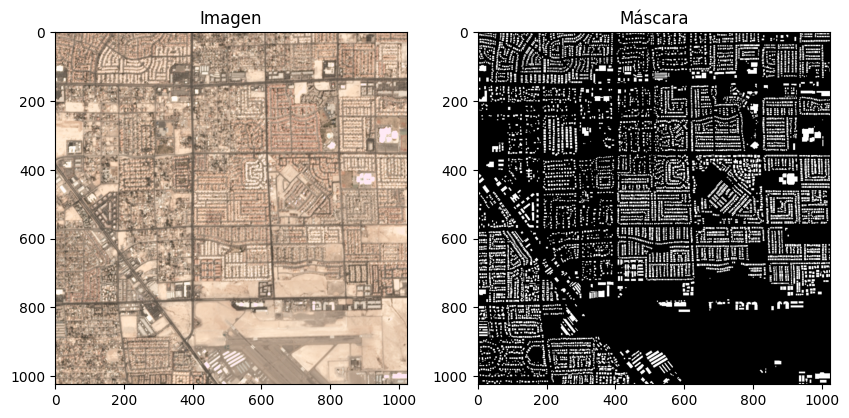

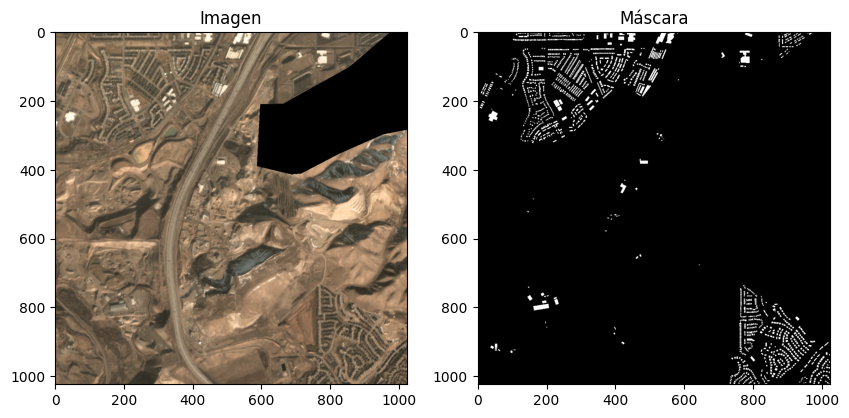

In [ ]:
# 4. Pintar algunas imágenes aleatorias del dataset junto con sus máscaras.
image_files = [f for f in os.listdir(OUTPUT_IMAGES_DIR) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(OUTPUT_MASKS_DIR) if f.endswith('.tif')]

sample_indices = np.random.choice(len(image_files), 5, replace=False)

for idx in sample_indices:
    img_path = os.path.join(OUTPUT_IMAGES_DIR, image_files[idx])
    mask_path = os.path.join(OUTPUT_MASKS_DIR, mask_files[idx])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Máscara")

    plt.show()

## Crear DataSet al 50-50

Haremos pruebas entrenando el modelo usando los dos datasets que tenemos al completo, o combinando ambos datasets a partes iguales. De esta forma confeccionamos nuestro propio conjunto de datos y podemos comprobar que tipo de mezcla nos proporciona mejores resultados.

In [ ]:
import os
import shutil
import random

In [ ]:
from google.colab import files, drive

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

In [ ]:
# Definimos las carpetas
ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/"

IMAGES_DIR = os.path.join(ROOT_DIR, "spacenet/Images")
MASKS_DIR = os.path.join(ROOT_DIR, "spacenet/Masks")

INRIA_IMAGES_DIR = os.path.join(ROOT_DIR, "Processed Images")
INRIA_MASKS_DIR = os.path.join(ROOT_DIR, "Processed Masks")

DISCARDED_IMAGES_DIR = os.path.join(ROOT_DIR, "Discarded Images")
DISCARDED_MASKS_DIR = os.path.join(ROOT_DIR, "Discarded Masks")

In [ ]:
# Obtenemos las imágenes con el prefijo "empty_"
empty_images = [img for img in os.listdir(INRIA_IMAGES_DIR) if img.startswith("empty_")]

# Mueve las imágenes con el prefijo "empty_" y sus correspondientes máscaras
for image_name in empty_images:
    shutil.move(os.path.join(INRIA_IMAGES_DIR, image_name), DISCARDED_IMAGES_DIR) # Images
    shutil.move(os.path.join(INRIA_MASKS_DIR, image_name), DISCARDED_MASKS_DIR) # Masks

print(f"Se han movido {len(empty_images)} imágenes y máscaras con el prefijo 'empty_'.")


# Obtenemos las imágenes en la carpeta destino para saber cuantas debemos mover
inria_images = os.listdir(INRIA_IMAGES_DIR)
# Obtenemos las imágenes en la carpeta del dataset
spacenet_images = os.listdir(IMAGES_DIR)

if len(inria_images) > len(spacenet_images):
    images_to_move = random.sample(inria_images, len(spacenet_images)) # Seleccionamos las imágenes del dataset INRIA
    # Movemos las imágenes seleccionadas y sus correspondientes máscaras
    for image_name in images_to_move:
        shutil.move(os.path.join(INRIA_IMAGES_DIR, image_name), IMAGES_DIR)
        shutil.move(os.path.join(INRIA_MASKS_DIR, image_name), MASKS_DIR)

else:
    images_to_move = random.sample(spacenet_images, len(inria_images)) # Seleccionamos las imágenes del dataset SPACENET
    # Movemos las imágenes seleccionadas y sus correspondientes máscaras
    for image_name in images_to_move:
        shutil.move(os.path.join(IMAGES_DIR, image_name), INRIA_IMAGES_DIR)
        shutil.move(os.path.join(MASKS_DIR, image_name), INRIA_MASKS_DIR)

print(f"Se han movido {min(len(inria_images), len(spacenet_images))} imágenes y sus máscaras correspondientes.")

Se han movido 0 imágenes y máscaras con el prefijo 'empty_'.
Se han movido 238 imágenes y sus máscaras correspondientes.
